## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Подоприхин Максим Александрович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [6]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [7]:
images_train, labels_train = next(iter(train_loader))

In [8]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

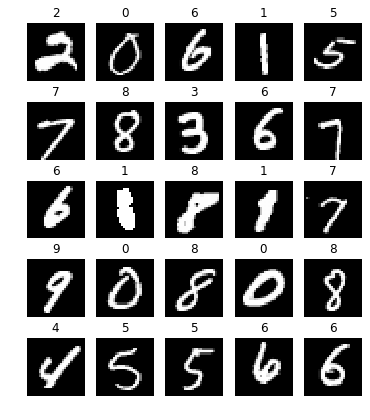

In [9]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [13]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [14]:
check(init_layer)

[Linear(in_features=784, out_features=500, bias=True), Linear(in_features=500, out_features=500, bias=True), Linear(in_features=500, out_features=500, bias=True), Linear(in_features=500, out_features=500, bias=True), Linear(in_features=500, out_features=500, bias=True), Linear(in_features=500, out_features=500, bias=True), Linear(in_features=500, out_features=500, bias=True), Linear(in_features=500, out_features=500, bias=True), Linear(in_features=500, out_features=500, bias=True), Linear(in_features=500, out_features=10, bias=True)]
forward 1.0119303464889526
forward 28.034374237060547
forward 624.7464599609375
forward 13806.3671875
forward 318060.65625
forward 7046617.0
forward 158074464.0
forward 3440911872.0
forward 76715704320.0
forward 1701814206464.0
backward 0.02260776422917843
backward 0.3073424994945526
backward 6.867040157318115
backward 149.73690795898438
backward 3165.619384765625
backward 68256.0234375
backward 1515432.375
backward 33964652.0
backward 748895104.0
backward

Наблюдаем взрыв градиента

In [15]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [16]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)

init_f = xavier_init_uni
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0119303464889526
forward 1.1204309463500977
forward 1.1179672479629517
forward 1.125339150428772
forward 1.1161158084869385
forward 1.1053982973098755
forward 1.1079902648925781
forward 1.1239855289459229
forward 1.1179088354110718
forward 1.1194401979446411
backward 0.02260776422917843
backward 0.019544534385204315
backward 0.018483879044651985
backward 0.018459651619195938
backward 0.019277766346931458
backward 0.01914995349943638
backward 0.01829311065375805
backward 0.018473748117685318
backward 0.019176367670297623
backward 0.01792539283633232


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [39]:
def check(init_f, func_act = None):
    net = []
    net.append(make_linear(28*28, 500, init_f))
    if func_act is not None:
        net.append(func_act)
    for i in range(8):
        net.append(make_linear(500, 500, init_f))
        if func_act is not None:
            net.append(func_act)
    net.append(make_linear(500, 10, init_f))
    net = nn.Sequential(*net)

    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = net(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()


In [40]:
def Xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    a = np.sqrt(6) / np.sqrt(weight.shape[0] + weight.shape[1])
    weight.uniform_(-a, a)
    
def He_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=np.sqrt(2/weight.shape[1]))

#### He с ReLU и Tanh

In [41]:
check(He_init, nn.ReLU())

forward 1.0119303464889526
forward 0.8555330634117126
forward 0.8567198514938354
forward 0.8639150261878967
forward 0.8540783524513245
forward 0.850945770740509
forward 0.8262297511100769
forward 0.7857409715652466
forward 0.7466638684272766
forward 0.7640149593353271
backward 0.02260776422917843
backward 0.012630533427000046
backward 0.011566703207790852
backward 0.010808074846863747
backward 0.00874987430870533
backward 0.007316088303923607
backward 0.006999546196311712
backward 0.006610484793782234
backward 0.006103958003222942
backward 0.005571240093559027


In [42]:
check(He_init, nn.Tanh())

forward 1.0119303464889526
forward 0.7145229578018188
forward 0.6260656714439392
forward 0.5960819721221924
forward 0.5766974091529846
forward 0.5711025595664978
forward 0.5614957809448242
forward 0.5589470863342285
forward 0.55829256772995
forward 0.5569918751716614
backward 0.02260776422917843
backward 0.014471999369561672
backward 0.01397981308400631
backward 0.014078710228204727
backward 0.013449685648083687
backward 0.012732181698083878
backward 0.012269848957657814
backward 0.012325841002166271
backward 0.011509806849062443
backward 0.008405636996030807


#### Xavier с ReLU, Tanh и без нелинейности

In [43]:
check(Xavier_init, nn.ReLU())

forward 1.0119303464889526
forward 0.6661478281021118
forward 0.4501330852508545
forward 0.31474658846855164
forward 0.23009341955184937
forward 0.16197805106639862
forward 0.12175404280424118
forward 0.0849134624004364
forward 0.06287164986133575
forward 0.049270279705524445
backward 0.02260776422917843
backward 0.011815364472568035
backward 0.008215272799134254
backward 0.005314543377608061
backward 0.0034919888712465763
backward 0.002238883636891842
backward 0.0014508346794173121
backward 0.0008777989423833787
backward 0.0005578706623055041
backward 0.0003684326075017452


In [44]:
check(Xavier_init, nn.Tanh())

forward 1.0119303464889526
forward 0.65412837266922
forward 0.48746493458747864
forward 0.4107530117034912
forward 0.3611578047275543
forward 0.323881059885025
forward 0.29828783869743347
forward 0.27604949474334717
forward 0.2559274435043335
forward 0.23891907930374146
backward 0.02260776422917843
backward 0.018405208364129066
backward 0.01710505038499832
backward 0.016456974670290947
backward 0.016551073640584946
backward 0.014493179507553577
backward 0.012589541263878345
backward 0.010016638785600662
backward 0.00742334546521306
backward 0.004453986883163452


In [45]:
check(Xavier_init)

forward 1.0119303464889526
forward 1.11408269405365
forward 1.1223653554916382
forward 1.1055485010147095
forward 1.1031494140625
forward 1.1043143272399902
forward 1.0907588005065918
forward 1.100380778312683
forward 1.122225284576416
forward 1.1111729145050049
backward 0.02260776422917843
backward 0.02028653398156166
backward 0.018987679854035378
backward 0.018325475975871086
backward 0.01779722049832344
backward 0.018436305224895477
backward 0.018102828413248062
backward 0.01882908120751381
backward 0.018098272383213043
backward 0.018628519028425217


<i> 1.4 Сделайте выводы по первой части </i>

Вцелом более умная инициализация выглядит адекватнее на фоне наивной инициализации. И так же эмпирически проверено, что Xavier для ReLU не очень хорошо работает, т.к. градиенты всё же затухают. Для HE же ReLU. Но во всех остальных случаях инициализация показала хороший результат.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [27]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [30]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    #net.append(DropConnect(in_dim, out_dim))
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.613/0.314	Accuracy: 0.845/0.925


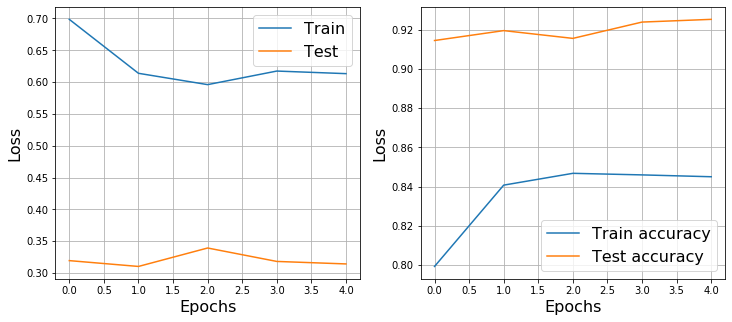

([0.698638383894841,
  0.613879518341154,
  0.5960795599133221,
  0.6174026098586857,
  0.6133446074497979],
 [0.3195667268731926,
  0.31042123859441734,
  0.3394010923331297,
  0.31829806728453575,
  0.3143790809414055],
 [0.7993848, 0.8408016, 0.84681505, 0.84601545, 0.8450715],
 [0.9144581, 0.9195016, 0.9155459, 0.92385286, 0.92523736])

In [31]:
train(net, train_loader, test_loader, 5, 0.01, device='cuda')

Epoch 4... (Train/Test) NLL: 0.251/0.159	Accuracy: 0.932/0.958


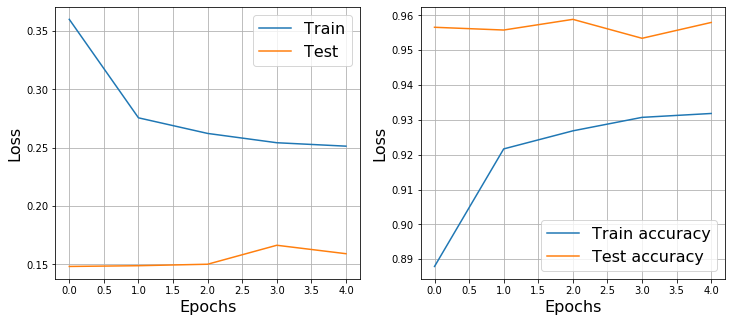

([0.36015503863091153,
  0.275709270271284,
  0.2623247703366569,
  0.25434841262474495,
  0.2514069686884057],
 [0.1482545633010472,
  0.1488834477112263,
  0.15015960135791875,
  0.16641749682117113,
  0.15918436255070229],
 [0.8879153, 0.921664, 0.92685014, 0.93072027, 0.93183637],
 [0.95658624, 0.9557951, 0.95886075, 0.95342165, 0.95797074])

In [29]:
train(net, train_loader, test_loader, 5, 0.01, device='cuda')

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

В данной ситуации DropConnect и Dropout показали себя не очень хорошо. Возможно, Dropout и DropConnect актуальны для глубоких сетей, где много весов и есть что выбрасывать. 

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [10]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        #print(x)
        output = (x - x.mean(-1, keepdim=True))/(x.std(-1, keepdim=True) + 1e-10)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [3]:
import sys

import warnings
warnings.filterwarnings("ignore")

In [4]:
dtype=torch.FloatTensor

def train_other(network, epochs, learning_rate, loss=nn.NLLLoss(), optim=torch.optim.Adam, conv=False):
    train_loss_epochs = []
    train_accuracy_epochs = []
    test_loss_epochs = []
    test_accuracy_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = Variable(X)
                X = X.view(X.shape[0], -1).type(dtype)
                y = Variable(y)
                #y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
  
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []    
            for sample in test_loader:
                X = Variable(X)
                X = X.view(X.shape[0], -1).type(dtype)
                y = Variable(y)
                #y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

Epoch 9... (Train/Test) NLL: 0.024/0.002	Accuracy: 0.992/0.993

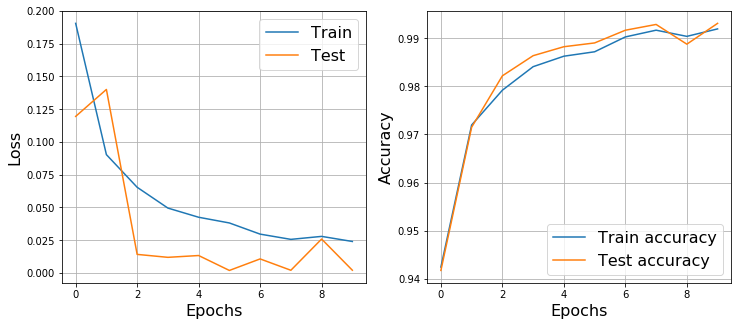

In [8]:
network = nn.Sequential(nn.Linear(28*28, 200), 
                        nn.BatchNorm1d(num_features=200, track_running_stats = False),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(num_features=200, track_running_stats = False),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_other(network, 10, 1e-2)

Epoch 9... (Train/Test) NLL: 0.028/0.004	Accuracy: 0.990/0.992

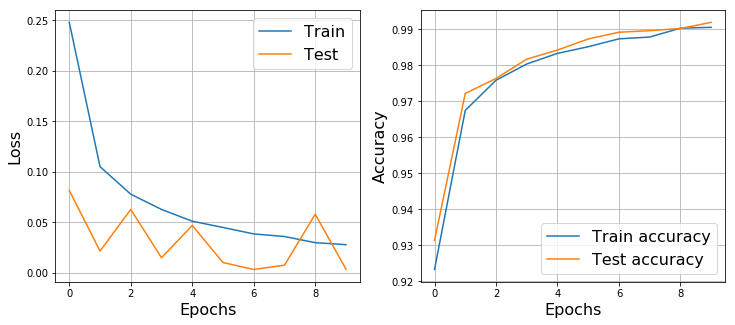

In [11]:
network = nn.Sequential(nn.Linear(28*28, 200), 
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_other(network, 10, 1e-2)

<i> 3.3 Сделайте выводы по третьей части </i>

Что Batch normalization, что layer normalization показывают себя хорошо, при этом улучшая результаты, по сравнению с тем, если бы эти слои не использовались

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: